<a href="https://colab.research.google.com/github/abhi7275/Google-Stock-Price-Prediction/blob/main/GoogleStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is Notebook which is used to analysis the time series stock price of Google, we extracted the dataset from GoogleFinance

In [2]:
import matplotlib.pyplot as plt                                                 #Importing matplotlib to plot and analyse data.
import pandas as pd
import plotly.express as px                                                  
from pandas import read_csv
from prophet import Prophet                                                   #Importing prophet (prediction and forecasting library.)


In [4]:
#Extracted Google Finance data from GoogleFinance Spreadsheet and only extracted the date time and stock close value
df = pd.read_csv('GoogleFinance.csv')

In [5]:
df.head()

,Date,Close
0,1/3/2022 16:00:00,145.07
1,1/4/2022 16:00:00,144.42
2,1/5/2022 16:00:00,137.65
3,1/6/2022 16:00:00,137.55
4,1/7/2022 16:00:00,137.00


In [6]:
#We are going to use Facebook Prophet algorithm for time series forecasting and Fb Prophet takes only two argument in input ds and y
#Rename date as ds and CLose as y
df.rename(columns = {'Date': 'ds'}, inplace = True)
df.rename(columns = {'Close': 'y'}, inplace = True)

In [7]:
df.head()

,ds,y
0,1/3/2022 16:00:00,145.07
1,1/4/2022 16:00:00,144.42
2,1/5/2022 16:00:00,137.65
3,1/6/2022 16:00:00,137.55
4,1/7/2022 16:00:00,137.00


In [10]:
#As we can see there is no hourly data in google dataset, only daily data so we can remove time from ds column
df['ds'] = pd.to_datetime(df['ds']).dt.date

In [12]:
df.head()

,ds,y
0,2022-01-03,145.07
1,2022-01-04,144.42
2,2022-01-05,137.65
3,2022-01-06,137.55
4,2022-01-07,137.00


In [13]:
fig = px.line(df, x='ds', y='y')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12
import random
random.seed(12)

Text(0.5, 0.98, '\nMultiplicative Decompose')

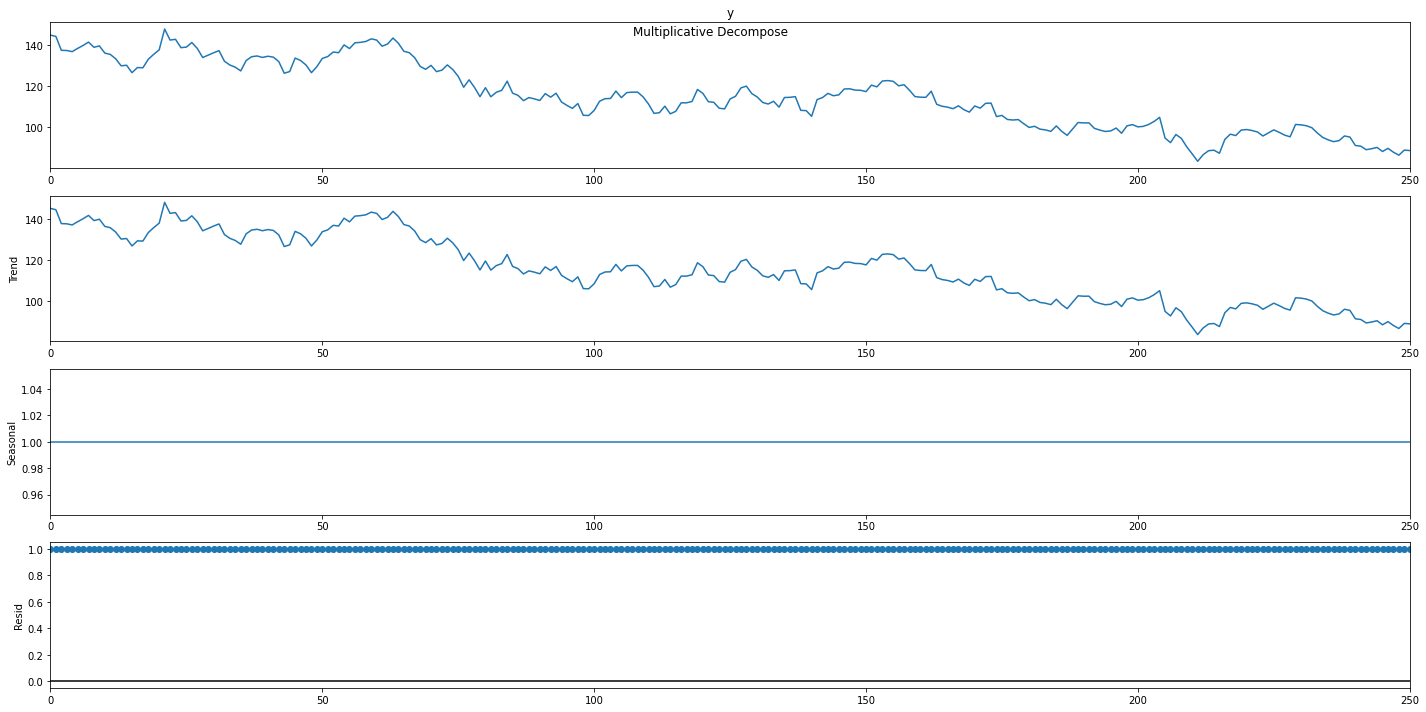

In [17]:
#Lets decompose the dataset to look the trends and seasonality 
multi_seas = seasonal_decompose(df['y'], model = 'multiplicative', period = 1)
plt.rcParams.update({'figure.figsize':(20,10)})
multi_seas.plot().suptitle('\nMultiplicative Decompose', fontsize=12)


In [18]:
#We can clearly see above that there is downward trend and no seasonality
#Now lets check the timeseries data is stationary or not using AdFuller technique
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df.y.values, autolag='AIC')
print(f'ADF Statistic: {adf_result[0]}')
if adf_result[0] < 0.05:
  print(f'Data is stationary, p-value: {adf_result[1]}')
else:
  print(f'Data is non-stationary, p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -1.5210779496787494
Data is stationary, p-value: 0.5230598098454871
Critial Values:
   1%, -3.456780859712
Critial Values:
   5%, -2.8731715065600003
Critial Values:
   10%, -2.572968544


In [34]:
df.ds = pd.to_datetime(df['ds'])

In [35]:
#Lets do train and test split
# So taking 10 months of data as end date and 2 months of data as test data and mask to make train and test data 
end_date = '2022-10-30'
mask1 = (df['ds'] <= end_date)
mask2 = (df['ds'] > end_date)


In [36]:
train_data = df.loc[mask1]
test_data = df.loc[mask2]
print("train shape",train_data.shape)
print("test shape",test_data.shape)

train shape (208, 2)
test shape (43, 2)


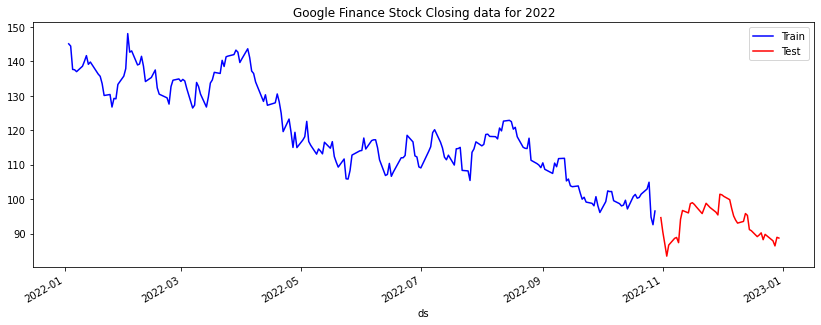

In [37]:
#Blue line is train data and red is test data
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
train_data.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
test_data.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Google Finance Stock Closing data for 2022')
plt.show()

In [39]:
model =Prophet()
model.fit(train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphziqn4ub/tzup7krj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphziqn4ub/jx7qcu8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18104', 'data', 'file=/tmp/tmphziqn4ub/tzup7krj.json', 'init=/tmp/tmphziqn4ub/jx7qcu8x.json', 'output', 'file=/tmp/tmphziqn4ub/prophet_modelmzzn4eik/prophet_model-20230127141407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:14:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:14:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [40]:
future = model.make_future_dataframe(periods=43, freq='D')
forecast = model.predict(future)

In [41]:
forecast_final = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

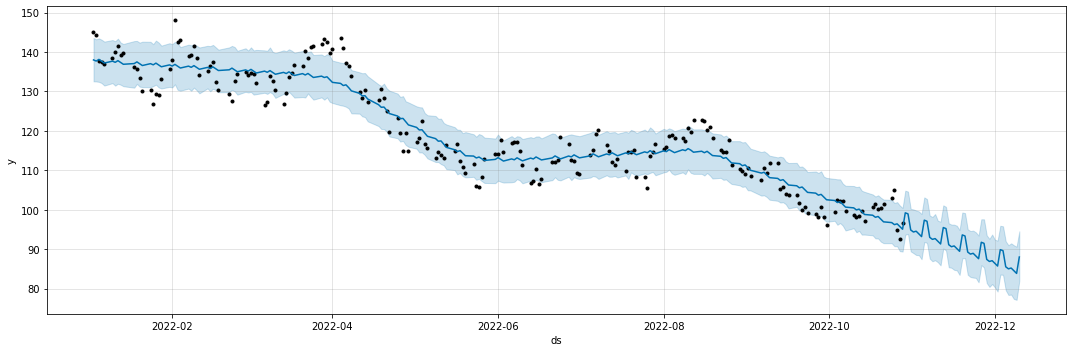

In [50]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast_final,ax=ax)
plt.show()

In [42]:
forecast_final.tail()

,ds,yhat,yhat_lower,yhat_upper
246,2022-12-06,85.001130,78.372375,90.986142
247,2022-12-07,85.203239,78.465330,91.473051
248,2022-12-08,84.513278,77.362332,90.980576
249,2022-12-09,83.838832,77.135981,90.627634
250,2022-12-10,88.000034,81.967041,94.526108


Compare the Actual vs Prediction dataset

In [43]:
Test_forecast = model.predict(test_data)
prediction_forecast = Test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

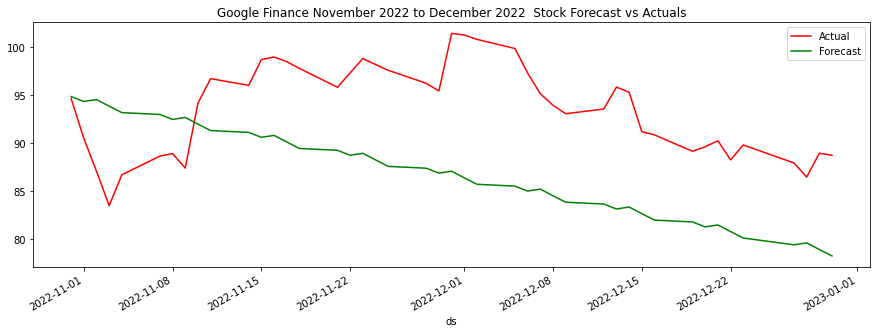

In [47]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test_data.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
prediction_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Google Finance November 2022 to December 2022  Stock Forecast vs Actuals')
plt.show()

In [46]:
#Calculate model accuracy
from sklearn.metrics import mean_squared_error
import math
import numpy as np
mse = mean_squared_error(test_data['y'],prediction_forecast['yhat'])
rmse = math.sqrt(mse)
print(rmse)

9.155335306029752


I can improve this General Forecasting Model by tuning the hyperparameters, preprocessing the data, detecting outliers, and evaluating the accuracy using metrics such as MAPE and RMSE.